In [ ]:
import pandas as pd
import re
from collections import Counter

# 1. Load the raw CSV
df = pd.read_csv("original.csv")  # path as needed

# 2. Parse "['Good' 'vibe' 'tribe']" → ['Good','vibe','tribe']
def parse_quoted_list(s):
    return re.findall(r"'(.*?)'", str(s), flags=re.DOTALL)

df["tokens"] = df["words"].apply(parse_quoted_list)
df["labels"] = df["lid"].apply(parse_quoted_list)

# 3. Drop rows with token/label length mismatch
mask = df["tokens"].str.len() == df["labels"].str.len()
print("Total rows:", len(df))
print("Rows with mismatch:", (~mask).sum())

df_clean = df[mask].reset_index(drop=True)
print("Rows after cleaning:", len(df_clean))

# 4. Label distribution + mappings
label_counter = Counter()
for labs in df_clean["labels"]:
    label_counter.update(labs)

print("Label distribution:", label_counter)

unique_labels = sorted(label_counter.keys())
label2id = {lab: i for i, lab in enumerate(unique_labels)}
id2label = {i: lab for lab, i in label2id.items()}
print("Labels:", unique_labels)

df_clean["label_ids"] = df_clean["labels"].apply(
    lambda labs: [label2id[l] for l in labs]
)

Total rows: 4823
Rows with mismatch: 588
Rows after cleaning: 4235
Label distribution: Counter({'lang1': 39994, 'lang2': 18011, 'other': 11064, 'ne': 5312, 'fw': 387, 'mixed': 27, 'unk': 10, 'ambiguous': 8})
Labels: ['ambiguous', 'fw', 'lang1', 'lang2', 'mixed', 'ne', 'other', 'unk']


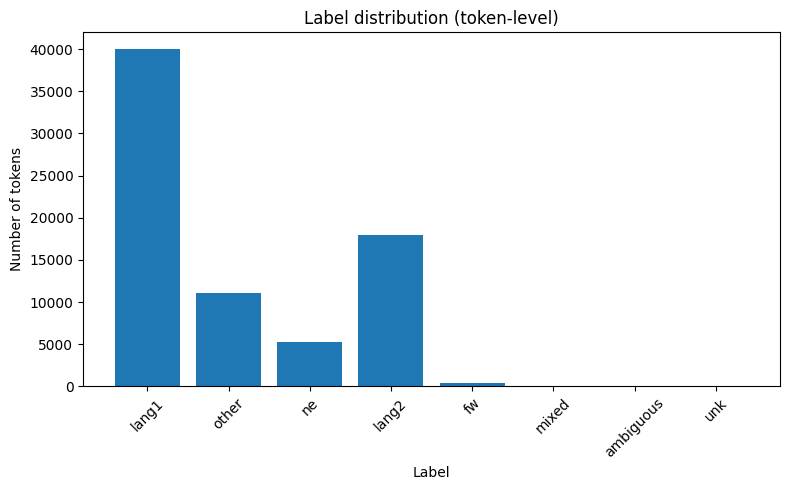

In [ ]:
import matplotlib.pyplot as plt

# Flatten all labels
all_labels = [lab for labs in df_clean["labels"] for lab in labs]

label_counts = Counter(all_labels)
labels = list(label_counts.keys())
counts = [label_counts[l] for l in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title("Label distribution (token-level)")
plt.xlabel("Label")
plt.ylabel("Number of tokens")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

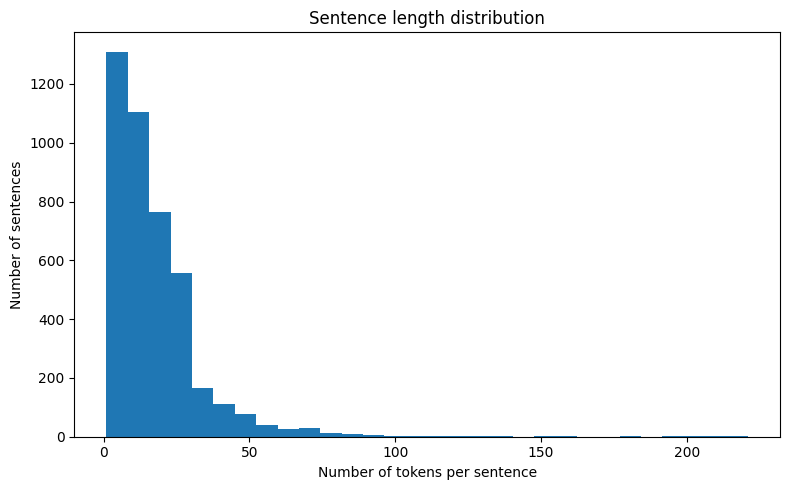

In [ ]:
# Number of tokens per sentence
sentence_lengths = df_clean["tokens"].apply(len)

plt.figure(figsize=(8, 5))
plt.hist(sentence_lengths, bins=30)
plt.title("Sentence length distribution")
plt.xlabel("Number of tokens per sentence")
plt.ylabel("Number of sentences")
plt.tight_layout()
plt.show()


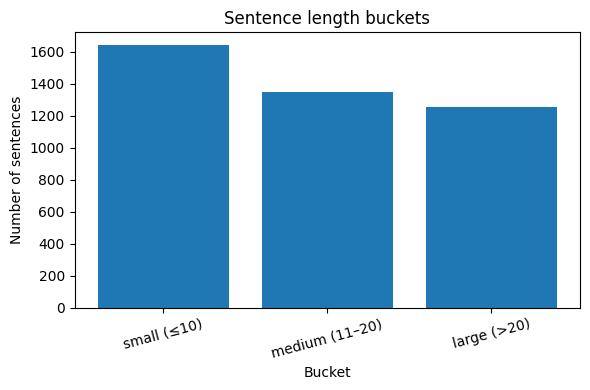

In [ ]:
def length_bucket(n):
    if n <= 10:
        return "small (≤10)"
    elif n <= 20:
        return "medium (11–20)"
    else:
        return "large (>20)"

df_clean["len_bucket"] = sentence_lengths.apply(length_bucket)
bucket_counts = df_clean["len_bucket"].value_counts().reindex(
    ["small (≤10)", "medium (11–20)", "large (>20)"]
)

plt.figure(figsize=(6, 4))
plt.bar(bucket_counts.index, bucket_counts.values)
plt.title("Sentence length buckets")
plt.xlabel("Bucket")
plt.ylabel("Number of sentences")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


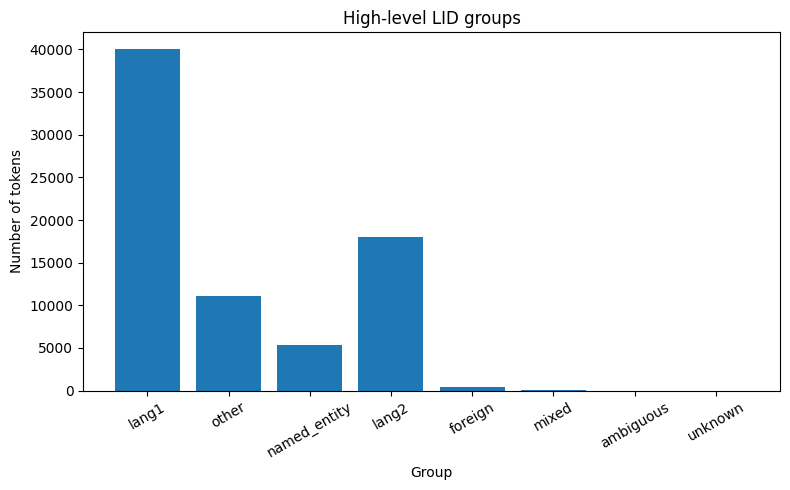

In [ ]:
group_map = {
    "lang1": "lang1",
    "lang2": "lang2",
    "ne": "named_entity",
    "fw": "foreign",
    "mixed": "mixed",
    "ambiguous": "ambiguous",
    "unk": "unknown",
    "other": "other"
}

group_counts = Counter(group_map[l] for l in all_labels)

groups = list(group_counts.keys())
g_counts = [group_counts[g] for g in groups]

plt.figure(figsize=(8, 5))
plt.bar(groups, g_counts)
plt.title("High-level LID groups")
plt.xlabel("Group")
plt.ylabel("Number of tokens")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split

df = pd.read_csv("original.csv")  # adjust path if needed

def parse_quoted_list(s):
    return re.findall(r"'(.*?)'", str(s), flags=re.DOTALL)

df["tokens"] = df["words"].apply(parse_quoted_list)
df["labels"] = df["lid"].apply(parse_quoted_list)

mask = df["tokens"].str.len() == df["labels"].str.len()
print("Total rows:", len(df))
print("Rows with mismatch:", (~mask).sum())

df_clean = df[mask].reset_index(drop=True)
print("Rows after cleaning:", len(df_clean))

label_counter = Counter()
for labs in df_clean["labels"]:
    label_counter.update(labs)

unique_labels = sorted(label_counter.keys())
label2id = {lab: i for i, lab in enumerate(unique_labels)}
id2label = {i: lab for lab, i in label2id.items()}

print("Labels:", unique_labels)
print("label2id:", label2id)

Total rows: 4823
Rows with mismatch: 588
Rows after cleaning: 4235
Labels: ['ambiguous', 'fw', 'lang1', 'lang2', 'mixed', 'ne', 'other', 'unk']
label2id: {'ambiguous': 0, 'fw': 1, 'lang1': 2, 'lang2': 3, 'mixed': 4, 'ne': 5, 'other': 6, 'unk': 7}


In [ ]:
!pip install seqeval --upgrade
import os
import json
import shutil
from collections import Counter

import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from seqeval.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)
import pandas as pd


class CodeSwitchLIDRunner:
    def __init__(
        self,
        df_clean,
        label2id,
        id2label,
        model_names,
        max_seq_length=128,
        seed=42,
    ):
        self.df = df_clean.copy()
        self.label2id = label2id
        self.id2label = id2label
        self.label_list = [id2label[i] for i in range(len(id2label))]
        self.model_names = model_names
        self.max_seq_length = max_seq_length
        self.seed = seed

        self.datasets = None   # HF DatasetDict
        self.tokenizer = None
        self.tokenized_datasets = None

        self.results = []      # summary metrics for all models

    # ---------- DATA SPLIT ----------

    def prepare_datasets(self, test_size=0.1, val_size=0.1):
        train_val_df, test_df = train_test_split(
            self.df,
            test_size=test_size,
            random_state=self.seed,
            shuffle=True,
        )

        relative_val_size = val_size / (1.0 - test_size)
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=relative_val_size,
            random_state=self.seed,
            shuffle=True,
        )

        print(f"Train size: {len(train_df)}")
        print(f"Validation size: {len(val_df)}")
        print(f"Test size: {len(test_df)}")

        def df_to_hf(sub_df):
            return Dataset.from_dict(
                {
                    "tokens": sub_df["tokens"].tolist(),
                    "labels": sub_df["labels"].tolist(),
                }
            )

        train_dataset = df_to_hf(train_df)
        val_dataset = df_to_hf(val_df)
        test_dataset = df_to_hf(test_df)

        self.datasets = DatasetDict(
            {
                "train": train_dataset,
                "validation": val_dataset,
                "test": test_dataset,
            }
        )

    # ---------- TOKENIZATION & LABEL ALIGN ----------

    def _tokenize_and_align_labels(self, examples):
        tokenized_inputs = self.tokenizer(
            examples["tokens"],
            truncation=True,
            is_split_into_words=True,
            max_length=self.max_seq_length,
        )

        all_labels = examples["labels"]
        new_labels = []

        for i, labels in enumerate(all_labels):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []

            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(self.label2id[labels[word_idx]])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx

            new_labels.append(label_ids)

        tokenized_inputs["labels"] = new_labels
        return tokenized_inputs

    def tokenize_datasets_for_model(self, model_name):
        print(f"\nTokenizing for model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.tokenized_datasets = self.datasets.map(
            self._tokenize_and_align_labels,
            batched=True,
            remove_columns=["tokens", "labels"],
        )

    # ---------- METRICS ----------

    def compute_metrics(self, p):
        predictions, labels = p
        predictions = np.argmax(predictions, axis=-1)

        true_labels = []
        true_preds = []

        for pred_seq, label_seq in zip(predictions, labels):
            curr_true = []
            curr_pred = []
            for p_id, l_id in zip(pred_seq, label_seq):
                if l_id == -100:
                    continue
                curr_true.append(self.label_list[l_id])
                curr_pred.append(self.label_list[p_id])
            true_labels.append(curr_true)
            true_preds.append(curr_pred)

        precision = precision_score(true_labels, true_preds)
        recall = recall_score(true_labels, true_preds)
        f1 = f1_score(true_labels, true_preds)
        acc = accuracy_score(true_labels, true_preds)

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": acc,
        }

    # ---------- TRAIN ONE MODEL THEN CLEANUP ----------

    def train_one_model(
        self,
        model_name,
        base_output_dir="./tmp_training_dirs",
        metrics_dir="./metrics_only",
        num_train_epochs=3,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=8,
        learning_rate=5e-5,
    ):
        os.makedirs(base_output_dir, exist_ok=True)
        os.makedirs(metrics_dir, exist_ok=True)

        model_output_dir = os.path.join(
            base_output_dir, model_name.replace("/", "_")
        )
        os.makedirs(model_output_dir, exist_ok=True)

        # 1. Tokenize for this model
        self.tokenize_datasets_for_model(model_name)

        # 2. Load model
        model = AutoModelForTokenClassification.from_pretrained(
            model_name,
            num_labels=len(self.label_list),
            id2label=self.id2label,
            label2id=self.label2id,
        )

        # 3. GPU + disk friendly TrainingArguments
        training_args = TrainingArguments(
            output_dir=model_output_dir,

            num_train_epochs=num_train_epochs,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=8,
            gradient_accumulation_steps=gradient_accumulation_steps,
            learning_rate=learning_rate,
            weight_decay=0.01,
            warmup_ratio=0.1,
            max_grad_norm=1.0,

            fp16=torch.cuda.is_available(),

            eval_strategy="epoch",
            save_strategy="no",      # 🔴 NO CHECKPOINTS SAVED
            logging_strategy="steps",
            logging_steps=100,

            load_best_model_at_end=False,
            report_to="none",
        )
        data_collator = DataCollatorForTokenClassification(self.tokenizer)

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=self.tokenized_datasets["train"],
            eval_dataset=self.tokenized_datasets["validation"],
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
        )

        print(f"\n===== Training {model_name} ====")
        trainer.train()

        print(f"\n===== Evaluating {model_name} on TEST set ====")
        test_results = trainer.evaluate(self.tokenized_datasets["test"])

        # 4. Detailed classification report
        preds_output = trainer.predict(self.tokenized_datasets["test"])
        preds = np.argmax(preds_output.predictions, axis=-1)
        label_ids = preds_output.label_ids

        true_labels = []
        true_preds = []

        for pred_seq, label_seq in zip(preds, label_ids):
            curr_true = []
            curr_pred = []
            for p_id, l_id in zip(pred_seq, label_seq):
                if l_id == -100:
                    continue
                curr_true.append(self.label_list[l_id])
                curr_pred.append(self.label_list[p_id])
            true_labels.append(curr_true)
            true_preds.append(curr_pred)

        cls_report = classification_report(true_labels, true_preds)

        # 5. Save ONLY lightweight metric files
        safe_name = model_name.replace("/", "_")
        metrics_path = os.path.join(metrics_dir, f"{safe_name}_test_metrics.json")
        report_path = os.path.join(metrics_dir, f"{safe_name}_classification_report.txt")

        with open(metrics_path, "w") as f:
            json.dump(
                {k: float(v) if isinstance(v, (np.floating, np.float32, np.float64)) else v
                 for k, v in test_results.items()},
                f,
                indent=2,
            )

        with open(report_path, "w") as f:
            f.write(cls_report)

        # 6. Add to in-memory summary table
        summary_row = {
            "model_name": model_name,
            "num_train_epochs": num_train_epochs,
            "per_device_train_batch_size": per_device_train_batch_size,
            "gradient_accumulation_steps": gradient_accumulation_steps,
            "learning_rate": learning_rate,
        }
        for k, v in test_results.items():
            summary_row[f"test_{k}"] = float(v) if isinstance(v, (np.floating, np.float32, np.float64)) else v

        self.results.append(summary_row)

        # 7. CLEANUP: free GPU + tokenized data + training folder
        del trainer
        del model
        torch.cuda.empty_cache()

        del self.tokenized_datasets
        del self.tokenizer

        shutil.rmtree(model_output_dir, ignore_errors=True)
        print(f"Cleaned up training dir for {model_name}")

    # ---------- RUN ALL MODELS SEQUENTIALLY ----------

    def run_all_models(self, **train_kwargs):
        if self.datasets is None:
            raise ValueError("Call prepare_datasets() before run_all_models().")

        for model_name in self.model_names:
            self.train_one_model(model_name, **train_kwargs)

        results_df = pd.DataFrame(self.results)
        results_df.to_csv("all_model_results.csv", index=False)
        print("\n===== All model results =====")
        print(results_df)
        return results_df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=c0992b3114d33b56bbca03f6eb31aa9a13827fcecbc6986c5988af5d6fc6c7f8
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [ ]:
model_names = [
    "xlm-roberta-base",
    "bert-base-multilingual-cased",
    # "ai4bharat/indic-bert", # Removed due to gated repo access
    "distilbert/distilbert-base-multilingual-cased",
]

runner = CodeSwitchLIDRunner(
    df_clean=df_clean,
    label2id=label2id,
    id2label=id2label,
    model_names=model_names,
    max_seq_length=128,
    seed=42,
)

# Step 2: Build HF datasets (CPU only)
runner.prepare_datasets(test_size=0.1, val_size=0.1)

# Step 3: Train models one after another,
# and store only important metrics + delete heavy stuff
results_df = runner.run_all_models(
    base_output_dir="./tmp_training_dirs",  # will be cleaned per model
    metrics_dir="./metrics_only",          # small JSON/TXT files
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
)

Train size: 3387
Validation size: 424
Test size: 424

Tokenizing for model: xlm-roberta-base


Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1158093121.py:223: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== Training xlm-roberta-base ====


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.605700,0.168748,0.823259,0.837168,0.830155,0.949980
2,0.148200,0.152957,0.851371,0.848311,0.849838,0.955062
3,0.111300,0.143482,0.860065,0.861610,0.860837,0.958807


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ne seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: fw seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171:


===== Evaluating xlm-roberta-base on TEST set ====


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cleaned up training dir for xlm-roberta-base

Tokenizing for model: bert-base-multilingual-cased


Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1158093121.py:223: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== Training bert-base-multilingual-cased ====


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.487800,0.192159,0.811881,0.826196,0.818976,0.946073
2,0.147300,0.176258,0.845762,0.836632,0.841172,0.952228
3,0.097600,0.175981,0.847834,0.852105,0.849964,0.956510


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ne seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: fw seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171:


===== Evaluating bert-base-multilingual-cased on TEST set ====


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cleaned up training dir for bert-base-multilingual-cased

Tokenizing for model: distilbert/distilbert-base-multilingual-cased


Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1158093121.py:223: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== Training distilbert/distilbert-base-multilingual-cased ====


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.548900,0.195072,0.811451,0.800648,0.806013,0.944199
2,0.150100,0.186688,0.818703,0.822238,0.820467,0.947812
3,0.104600,0.177209,0.833095,0.836992,0.835039,0.952228


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ne seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: fw seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171:


===== Evaluating distilbert/distilbert-base-multilingual-cased on TEST set ====


Cleaned up training dir for distilbert/distilbert-base-multilingual-cased

===== All model results =====
                                      model_name  num_train_epochs  \
0                               xlm-roberta-base                 3   
1                   bert-base-multilingual-cased                 3   
2  distilbert/distilbert-base-multilingual-cased                 3   

   per_device_train_batch_size  gradient_accumulation_steps  learning_rate  \
0                            4                            8        0.00005   
1                            4                            8        0.00005   
2                            4                            8        0.00005   

   test_eval_loss  test_eval_precision  test_eval_recall  test_eval_f1  \
0        0.129763             0.870706          0.879478      0.875070   
1        0.141638             0.856824          0.859381      0.858101   
2        0.142790             0.841170          0.847445      0.844296   

   t

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_4 = "microsoft/mdeberta-v3-base"   # <-- choose your 4th model here

runner4 = CodeSwitchLIDRunner(
    df_clean=df_clean,
    label2id=label2id,
    id2label=id2label,
    model_names=[model_4],     # <-- ONLY MODEL 4 HERE
    max_seq_length=128,
    seed=42,
)

# prepare datasets (same as used for the previous 3 models)
runner4.prepare_datasets(test_size=0.1, val_size=0.1)

# train/evaluate model 4 using your class (same OOP flow, no changes)
runner4.train_one_model(
    model_name=model_4,
    base_output_dir="./tmp_training_dirs",
    metrics_dir="./metrics_only",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
)

# convert result to DataFrame
results_4_df = pd.DataFrame(runner4.results)
results_4_df

Train size: 3387
Validation size: 424
Test size: 424

Tokenizing for model: microsoft/mdeberta-v3-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1158093121.py:223: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



===== Training microsoft/mdeberta-v3-base ====


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.681400,0.175527,0.840925,0.858984,0.849858,0.954025
2,0.142400,0.159976,0.861522,0.855047,0.858272,0.957623
3,0.103400,0.146490,0.870450,0.872942,0.871694,0.961354


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ne seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: lang2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: fw seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171:


===== Evaluating microsoft/mdeberta-v3-base on TEST set ====


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cleaned up training dir for microsoft/mdeberta-v3-base


,model_name,num_train_epochs,per_device_train_batch_size,gradient_accumulation_steps,learning_rate,test_eval_loss,test_eval_precision,test_eval_recall,test_eval_f1,test_eval_accuracy,test_eval_runtime,test_eval_samples_per_second,test_eval_steps_per_second,test_epoch
0,microsoft/mdeberta-v3-base,3,4,8,0.00005,0.125189,0.878844,0.884415,0.881621,0.966887,1.5643,271.045,33.881,3.0


In [ ]:
existing = pd.read_csv("all_model_results.csv")
updated = pd.concat([existing, results_4_df], ignore_index=True)

updated.to_csv("all_model_results.csv", index=False)

updated

,model_name,num_train_epochs,per_device_train_batch_size,gradient_accumulation_steps,learning_rate,test_eval_loss,test_eval_precision,test_eval_recall,test_eval_f1,test_eval_accuracy,test_eval_runtime,test_eval_samples_per_second,test_eval_steps_per_second,test_epoch
0,xlm-roberta-base,3,4,8,0.00005,0.129763,0.870706,0.879478,0.875070,0.964394,0.9842,430.795,53.849,3.0
1,bert-base-multilingual-cased,3,4,8,0.00005,0.141638,0.856824,0.859381,0.858101,0.960979,1.0397,407.804,50.976,3.0
2,distilbert/distilbert-base-multilingual-cased,3,4,8,0.00005,0.142790,0.841170,0.847445,0.844296,0.958333,0.6234,680.088,85.011,3.0
3,microsoft/mdeberta-v3-base,3,4,8,0.00005,0.125189,0.878844,0.884415,0.881621,0.966887,1.5643,271.045,33.881,3.0
